# Network Analysis for Rebel Fund

Rebel Fund is a venture capital fund company. The aim of this project is to find the ideal pathways introductions to potential investors that will invest in Rebel Fund to raise milions of dollars of funds before it invest in capital with its limited partners. The method adapted is social network analysis of the Rebel's managers using a Graph theory. All the actors in a network are represented as nodes or vertex, where as relationship amongst them is called an edge or a link. According to Wasserman and Faust (1994), the three dimensions of social relations are direction, strength, and content. Direction indicates which actor sends or receives the relation, strength defines frequency of interaction between two nodes, and content defines a specific substantive connection among the nodes. The four attributes of the VC network are prominence, range, brokerage, and cohesion. 


## Data description
Flat data is provided by a data team that consists of identification of potential investors though LinkedIn seraches using some keyword. The mutual connections to the target investors and the clients (Rebel's two directors) is also provided, with some incomplete attributes such as company name, industry category and company empolyes size. A contact list from clients facebook account and emails is also pulled to access social relationship between them and their 1st degree connections. The information about the relationship between the connectors and target investors is missing, besides the social network information of each possible connector.

## Weighted Unidirectional Graph
Since, the main list of investors and connectors is pulled from LinkedIn, where link is up on both sides of the connection, a unidirectional graph is chosen as a network choice. Weights as penalties to the client and their 1st degree connection are added if the connectors have been already contacted in past and were marked as unfavourable by the client (+1) or if they have been not found in clients facebook or email contacts (+1). The default weight is 1, thus if a connector is either marked as unfavorable or is unsocial, the link between client and him/her will have a weight equal 3. Other attributes such as industries not in top 5 categories can be also added as third penalty weight between the client and their direct connections. To simply the problem further, a network of only one client is considered.

In [303]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
from IPython.display import display, HTML

CSS = """
.output {
    flex-direction: row;
}

"""

HTML('<style>{}</style>'.format(CSS))

Name: 
Type: Graph
Number of nodes: 852
Number of edges: 2160
Average degree:   5.0704


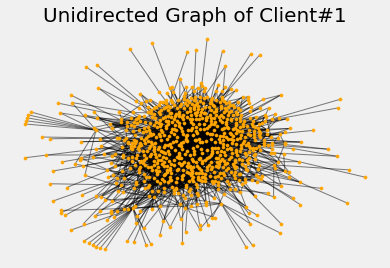

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import csv
from operator import itemgetter
import networkx as nx
from networkx.algorithms import community as community_X
from networkx.algorithms import bipartite
import community as community_louvain

with open('fake_nodes.csv', 'r') as nodecsv:  #rebel_valuable_nodes_with_header.csv
    nodereader = csv.reader(nodecsv) 
    nodes = [n for n in nodereader][1:]

node_names = [n[0] for n in nodes] # Get a list of only the node names

#print('nodes:', len(node_names))

G = nx.Graph()
G.add_nodes_from(node_names)

with open('fake_edges.csv', 'r') as edgecsv: # rebel_edges_with_header.csv
    edgereader = csv.reader(edgecsv)
    #print(edgereader)
    next(edgereader)
    for e in edgereader:
        #print (e)
        G.add_edge(e[0], e[1], weight = float(e[2]))

G.remove_nodes_from(['Richard Sussman'])
G.remove_nodes_from(list(nx.isolates(G)))
print(nx.info(G))        
#print(nx.info(G))

#G = nx.convert_node_labels_to_integers(G)

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (6, 4)
plt.style.use('fivethirtyeight')

#pos = nx.spring_layout(G)
pos = nx.spring_layout(G, k=0.1)

# drawing nodes
nx.draw_networkx_nodes(G, pos, node_size = 10, node_color = 'orange')

# drawing edges
nx.draw_networkx_edges(G, pos, width = 1, alpha = 0.5, edge_color = 'black')

# labels
#nx.draw_networkx_labels(G, pos, font_size = 4, font_family = 'sans-serif')

plt.title('Unidirected Graph of Client#1', fontsize = 20)
plt.axis('off')
plt.show()

## Basic Properties
Lets first check some properties of this network, such as density (0->1), articulation points (nodes that if removed can split the network in to disjoint sets), average short path, and the diameter of the largest components (disjoint sets or subgraphs), and triadic closure (closing a triangle of two strangers with a common friend in between them). 

Network density: 0.006
Articulation points: 49
Ave shortest path: 2.5352
Is connected graph?: True
Largest component diameter: 6
Triadic closure: 0.000346


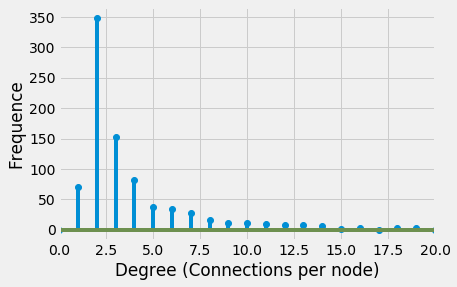

In [23]:
density = nx.density(G)
print("Network density:", round(density, 4))
articulation_points = len(list(nx.articulation_points(G)))
print('Articulation points:', articulation_points)
ave_short_path = nx.average_shortest_path_length(G)
print('Ave shortest path:', round(ave_short_path,4))

# check if its a connected graph, if not use the largest 
# component to determine the diameter
print('Is connected graph?:', nx.is_connected(G)) 
components = nx.connected_components(G)
largest_component = max(components, key=len)
#print(largest_component)
subgraph = G.subgraph(largest_component)
diameter = nx.diameter(subgraph)
print("Largest component diameter:", diameter)
triadic_closure = nx.transitivity(G)
print("Triadic closure:", round(triadic_closure,6))
#rc = nx.rich_club_coefficient(G, normalized=False)
#print(rc)
degree_freq = np.array(nx.degree_histogram(G)).astype('float')
                     
plt.figure(figsize=(6, 4))                       
plt.stem(degree_freq)

plt.xlim([0,20])

plt.ylabel("Frequence")
plt.xlabel("Degree (Connections per node)")
plt.show()

## Centrality Algorithms to Identify Potential Targets and Influencial Connectors (Hubs)
Centrality describes the prominence of the network. Centrality measures vary with the type of walk considered and the way of counting them, where a walk is a path which can go through the same node several times. In our data, the most connected nodes to other important nodes in the network can be ranked as important investors. On the otherhand, at times, it is important to identify the most connected hubs that can lead to many targets. In thoses casses closeness and similalrity between the nodes is more important.

**PageRank:** PageRank estimates a current node’s importance from its linked neighbors and then again from their respective neighbors.

**Eigenvector Centrality:** This gives more importance to nodes with well-connected neighbors.

**Degree Centrality:** Degree centrality measures incoming and outgoing relationship, and identify the most influential persons on a social network.

**Closeness Centrality:** It detects nodes that are can spread information efficiently through a graph.

**Betweeness Centrality:** It detects the amount of influence a node has over the flow of information in a graph. It is often used to find nodes that serve as a bridge from one part of a graph to another, also called hub.

In [24]:
c_pagerank_dict = nx.pagerank(G, alpha=0.9)# current node’s importance from its links and their neighbors
nx.set_node_attributes(G, c_pagerank_dict, 'pagerank')
sorted_pagerank = sorted(c_pagerank_dict.items(), key=itemgetter(1), reverse=True)

c_eigenvector_dict = nx.eigenvector_centrality_numpy(G) #find the hub, considering how many other hubs you are connected to
nx.set_node_attributes(G, c_eigenvector_dict, 'eigenvector')
sorted_eigenvector = sorted(c_eigenvector_dict.items(), key=itemgetter(1), reverse=True)
  
c_degree_dict = nx.degree_centrality(G) # shortest paths that pass through a particular node
nx.set_node_attributes(G, c_degree_dict, 'degreeness')
sorted_degree = sorted(c_degree_dict.items(), key=itemgetter(1), reverse=True)

c_closeness_dict = nx.closeness_centrality(G)
nx.set_node_attributes(G, c_closeness_dict, 'closeness')
sorted_closeness = sorted(c_closeness_dict.items(), key=itemgetter(1), reverse=True)

c_betweenness_dict = nx.betweenness_centrality(G) # shortest paths that pass through a particular node
nx.set_node_attributes(G, c_betweenness_dict, 'betweenness')
sorted_betweenness = sorted(c_betweenness_dict.items(), key=itemgetter(1), reverse=True)

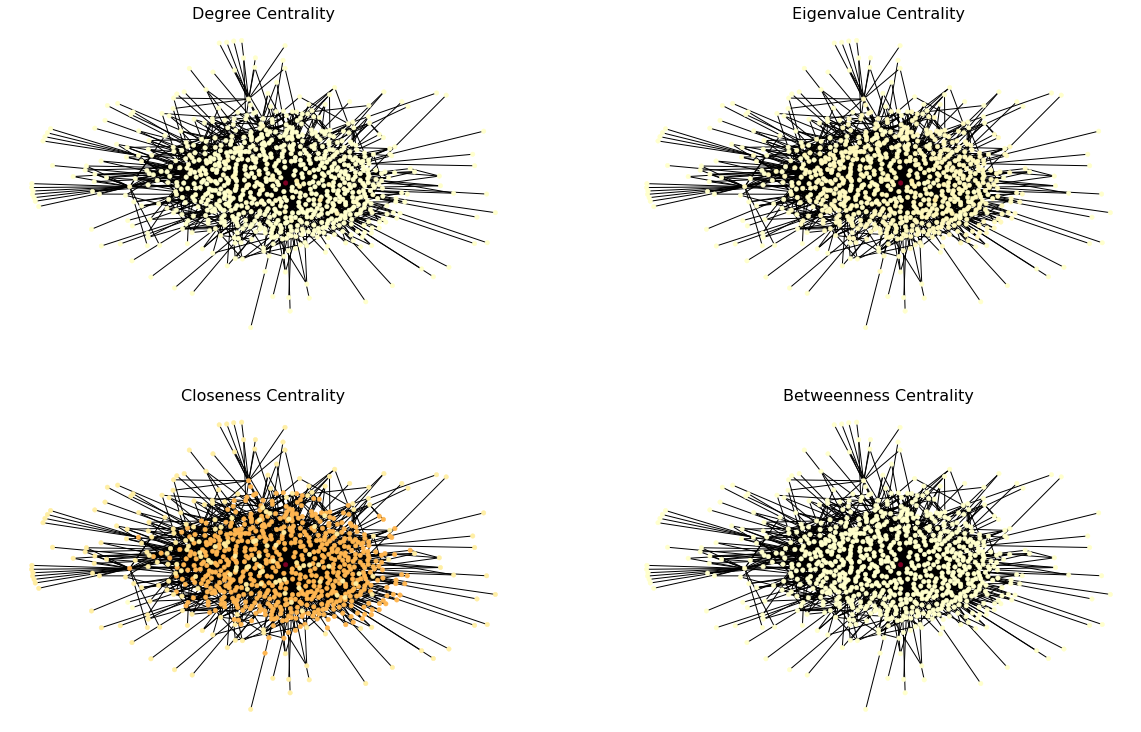

In [25]:
# Plot the centrality of the nodes
plt.figure(figsize=(18, 12))

pos = nx.spring_layout(G, k=0.1)

#plt.style.use('fivethirtyeight')

# Degree Centrality
f, axarr = plt.subplots(2, 2, num=1)

plt.sca(axarr[0,0])
nx.draw(G, cmap = plt.get_cmap('YlOrRd'), node_color = list(c_degree_dict.values()), node_size=20, pos=pos, with_labels=False)
axarr[0,0].set_title('Degree Centrality', size=16)

# Eigenvalue Centrality
plt.sca(axarr[0,1])
nx.draw(G, cmap = plt.get_cmap('YlOrRd'), node_color = list(c_eigenvector_dict.values()), node_size=20, pos=pos, with_labels=False)
axarr[0,1].set_title('Eigenvalue Centrality', size=16)

# Proximity Centrality
plt.sca(axarr[1,0])
nx.draw(G, cmap = plt.get_cmap('YlOrRd'), node_color = list(c_closeness_dict.values()), node_size=20, pos=pos, with_labels=False)
axarr[1,0].set_title('Closeness Centrality', size=16)

# Betweenness Centrality
plt.sca(axarr[1,1])
nx.draw(G, cmap = plt.get_cmap('YlOrRd'), node_color = list(c_betweenness_dict.values()), node_size=20, pos=pos, with_labels=False)
axarr[1,1].set_title('Betweenness Centrality', size=16)

plt.axis('off')
plt.show()

Since the C-centrality is anti-corelated to other metrics, it can be used to create a boundary between targets and connections. 

**Targets:** C-Centrality <=0.35

**Hubs:**   C-centrality > 0.35 

Lets also see them in tables. The table sorted by D-centrality points to the targets, where as the second table sorted by B-centrality points to the influencial pathway connections.

In [27]:
def get_top10_sorted_by_algo(sorted_dict, c_pagerank_dict, 
                                 c_degree_dict, c_eigenvector_dict, 
                                 c_betweenness_dict, c_closeness_dict, 
                                 size, list_name):
    
    name_np = np.array([]); name   = []
    deg_np  = np.array([]); deg  = []
    pr_np   = np.array([]); pr   = []
    bc_np   = np.array([]); bc   = []
    cc_np   = np.array([]); cc   = []
    e_np    = np.array([]); e    = []
    
    # for 1st 10 sorted values
    for tb in sorted_dict[:size]: 
        page_rank   = c_pagerank_dict[tb[0]]
        degree      = c_degree_dict[tb[0]] 
        eigen_value = c_eigenvector_dict[tb[0]]
        betweeness  = c_betweenness_dict[tb[0]] 
        closeness   = c_closeness_dict[tb[0]]
        #print("Name:", tb[0], "| Betweenness Centrality:", round(tb[1],3), "| Degree:", degree, "| Eigenvector:", eigen_value)
        pass_cut = False
        if list_name == 'Target': 
            pass_cut =  closeness <= 0.35#betweeness <=0.01
        elif list_name == 'Connector':
            pass_cut =  closeness > 0.35
        elif list_name == 'None':
            pass_cut = True
        
        if(pass_cut):
            name.append(tb[0]); 
            deg.append(round(degree,3)); 
            pr.append(round(page_rank,3))
            bc.append(round(betweeness,3)); 
            cc.append(round(closeness,3)); 
            e.append(round(eigen_value,3))
    
    name_np   = np.append(name_np, name)
    deg_np    = np.append(deg_np, deg)
    pr_np     = np.append(pr_np, pr)
    bc_np     = np.append(bc_np, bc)
    cc_np     = np.append(cc_np, cc)
    e_np      = np.append(e_np, e)
    df = pd.DataFrame({'Name':name_np, 'D-Centrality':deg_np, 
                         'PageRank':pr_np, 'EigenVector':e_np,
                         'B-Centrality': bc_np,'C-Centrality': cc_np
                        })

    return df
   

In [14]:
## degree centrality
df_dness = get_top10_sorted_by_algo(sorted_degree, 
                                    c_pagerank_dict, 
                                    c_degree_dict, 
                                    c_eigenvector_dict, 
                                    c_betweenness_dict, 
                                    c_closeness_dict, 
                                    11, 'None')
                                    
display(df_dness.iloc[1:].style.background_gradient(cmap='Oranges').format({'EigenVector': "{:.3f}", 
                                                                            'D-Centrality': "{:.3f}", 
                                                                            'PageRank': "{:.3f}",
                                                                            'C-Centrality':"{:.3f}",
                                                                            'B-Centrality': "{:.3f}"
                                                                           }))
## betweness centrality
df_bness = get_top10_sorted_by_algo(sorted_betweenness, 
                                    c_pagerank_dict, 
                                    c_degree_dict, 
                                    c_eigenvector_dict, 
                                    c_betweenness_dict, 
                                    c_closeness_dict, 
                                    11, 'None')
                                    
display(df_bness.iloc[1:].style.background_gradient(cmap='Oranges').format({'EigenVector': "{:.3f}", 
                                                                            'D-Centrality': "{:.3f}", 
                                                                            'PageRank': "{:.3f}",
                                                                            'C-Centrality':"{:.3f}",
                                                                            'B-Centrality': "{:.3f}"
                                                                           }))

,Name,D-Centrality,PageRank,EigenVector,B-Centrality,C-Centrality
1,Randy Lowe,0.089,0.012,0.094,0.007,0.341
2,Amber Bradley,0.067,0.009,0.071,0.006,0.349
3,Austin Taylor,0.057,0.008,0.059,0.004,0.339
4,Brittany Anderson,0.052,0.007,0.051,0.002,0.322
5,Lisa James,0.047,0.006,0.047,0.002,0.327
6,Joshua Bird,0.038,0.005,0.037,0.002,0.331
7,Regina Brown,0.036,0.005,0.038,0.002,0.335
8,Jacqueline Long,0.036,0.005,0.038,0.005,0.346
9,Sean Kennedy,0.036,0.005,0.037,0.002,0.325
10,David Hernandez,0.035,0.005,0.047,0.014,0.455


,Name,D-Centrality,PageRank,EigenVector,B-Centrality,C-Centrality
1,Rachel Anderson,0.030,0.006,0.031,0.035,0.451
2,William Stokes,0.026,0.004,0.033,0.016,0.450
3,Lisa Chung,0.014,0.003,0.029,0.014,0.443
4,David Hernandez,0.035,0.005,0.047,0.014,0.455
5,Blake Harris,0.032,0.004,0.040,0.012,0.452
6,Alexandra Reilly,0.012,0.002,0.028,0.011,0.444
7,Travis Hernandez,0.021,0.003,0.036,0.010,0.447
8,Sierra Donaldson,0.007,0.002,0.027,0.010,0.440
9,,0.026,0.004,0.022,0.008,0.324
10,Mr. Matthew Price,0.016,0.003,0.033,0.008,0.445


##  Top Targets and Hubs

Lets ranks the top targets as well as the influencial pathway connections in the network.

In [28]:
## Targets
df_target = get_top10_sorted_by_algo(sorted_degree, 
                                    c_pagerank_dict, 
                                    c_degree_dict, 
                                    c_eigenvector_dict, 
                                    c_betweenness_dict, 
                                    c_closeness_dict, 
                                    20, 'Target')
df_target = df_target.loc[:, ['Name','D-Centrality']]
display(df_target.iloc[0:10].style.background_gradient(cmap='Blues').format({}))

## Connectors
df_connector = get_top10_sorted_by_algo(sorted_betweenness, 
                                    c_pagerank_dict, 
                                    c_degree_dict, 
                                    c_eigenvector_dict, 
                                    c_betweenness_dict, 
                                    c_closeness_dict, 
                                    20, 'Connector')
df_connector = df_connector.loc[:, ['Name','B-Centrality']]
display(df_connector.iloc[1:11].style.background_gradient(cmap='Blues').format({}))
                                                                    

,Name,D-Centrality
0,Steve Robinson,0.089
1,Carly Mitchell,0.067
2,Joseph Hudson,0.058
3,Michael Scott,0.052
4,Christopher Pierce,0.047
5,Luis Ramos,0.038
6,John Brown,0.036
7,Rebecca Ramsey,0.036
8,Lindsay Prince,0.036
9,Matthew Johnson,0.031


,Name,B-Centrality
1,Elizabeth Soto,0.033
2,Timothy Mccann,0.018
3,Michele Madden,0.017
4,Christine Yang,0.013
5,Louis Wilson,0.012
6,Victoria Lynn,0.011
7,Jessica Evans,0.01
8,Anna Rodriguez,0.01
9,Sierra Carter,0.008
10,Mary Stone,0.006


## Shortest Path / Brokage

Once the top 10 target investors are identified, the most optimal pathways towards them is though using the Dijkstra theorem, as the network is weighted for the edges between client and connectors

In [29]:
top_target_list = [t.strip() for t in df_target['Name']]
s = 'Jared Heyman'

target_conn_dict = {}


for t in top_target_list:
    all_p=nx.all_shortest_paths(G,source=s, target=t, weight='weight')
    top_three = list(all_p)[0:3]  
    top_intro = [t[1] for t in top_three]
    #print('\n',top_three)
    #print('\n',t,':', top_intro)
    target_conn_dict[t] = top_intro
    
def show_subnet(G, t_in, s_in):
    plt.figure(figsize=(18, 18))
    H = nx.ego_graph(G, t_in, radius=2)
    
    n = H.number_of_nodes()
    m = H.number_of_edges()
    print("Number of nodes :", str(n))
    print("Number of edges :", str(m))
    print("Number of connected components :", str(nx.number_connected_components(H)))


    prediction_jaccard = list(nx.jaccard_coefficient(H))
    #print(prediction_jaccard)                          
    #score, label = zip(*[(s, (u,v) in H.edges()) for (u,v,s) in prediction_jaccard])
                              
    #print(score, label)

    pos = nx.kamada_kawai_layout(H)
    nx.draw_networkx(
        H, pos=pos, node_size=20, alpha=1.0, size = 900)
    p=nx.shortest_path(G,source=s_in, target=t_in, weight='weight' )
    #print(p)
    path_edges = zip(p,p[1:])
    path_edges = set(path_edges)
    nx.draw_networkx_nodes(H,pos,nodelist=p,node_color='r')
    nx.draw_networkx_edges(H,pos,edgelist=path_edges,edge_color='r',width=4)
    plt.rcParams['figure.figsize'] = (15, 15)
    plt.title('SubGraphs of '+t_in, fontsize = 20)
    plt.axis('off')
    plt.show()
    #plt.savefig(t_in+'_subnet.png')
    

#print(target_conn_dict)    
#t_0 = list(target_conn_dict.keys())[9]#pick number
#print(t_0)
#conn_0 = target_conn_dict[t_0]
#print(conn_0)

target_img_dict = {}
for i, t_in in enumerate(target_conn_dict.keys()):
    print (i, t_in)
    #show_subnet(G, t_0, s)
    #target_img_dict[t] = open(t_0+'_subnet.png')
    
#print('Target: ', t_0,'\nPathways:', conn_0)
#show_subnet(G, t_0, s)

#print(target_img_dict)




0 Steve Robinson
1 Carly Mitchell
2 Joseph Hudson
3 Michael Scott
4 Christopher Pierce
5 Luis Ramos
6 John Brown
7 Rebecca Ramsey
8 Lindsay Prince
9 Matthew Johnson
10 Aaron Singleton
11 Joanne Sanders
12 Brent Rangel
13 Amanda Stephenson
14 Russell Cook


In [ ]:
pick_target = input('\nEnter a number from 0-14 to pick a target')
t_0 = list(target_conn_dict.keys())[int(pick_target)]#pick a number
print('You have picked target ', t_0)
print('The best pathways are ', target_conn_dict[t_0])
show_subnet(G, t_0, s)


## Methodology (In Progress):
Given the missing attributes of target and connector relationship, the optimal solution which is shortest pathway may be unreliable. Therefore heuristic methods can be used to speed up the process of finding a satisfactory solution, by identifying all possible ranks through different algorithms and taking an average of them. 

# Max Clique (In Progress)

['Jared Heyman', 'Tony Pietrzak', 'Grant Groves']


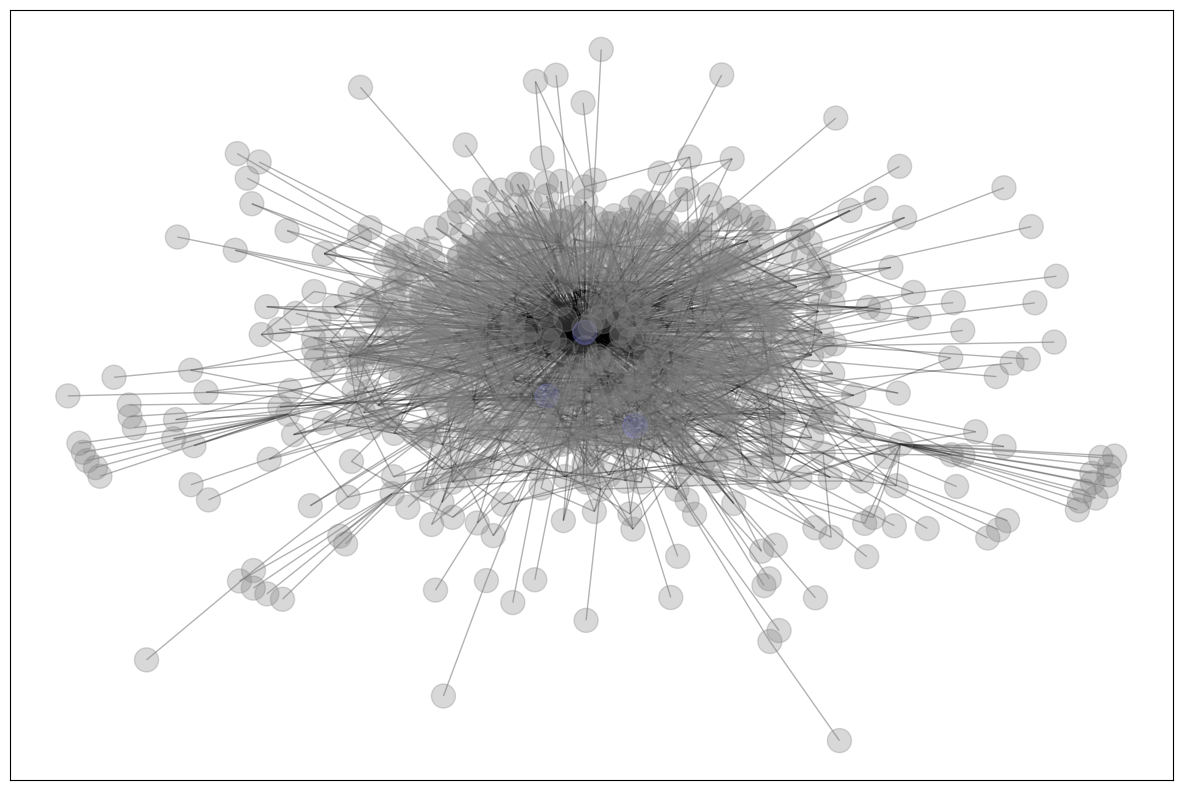

In [318]:
pos = nx.spring_layout(G)
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (15, 10)})
cliques = list(nx.find_cliques(G))

max_clique = max(cliques, key=len)
print(max_clique)
#print('all cliques')

#print(cliques)

node_color = [(0.5, 0.5, 0.5) for v in G.nodes()]
for i, v in enumerate(G.nodes()):
    if v in max_clique:
        node_color[i] = (0.5, 0.5, 0.9)
        
nx.draw_networkx(G, 
                 node_color=node_color, 
                 pos=pos,
                 alpha=0.3,
                 with_labels=False)

This needs a check: